### Comparing data with other studies
This notebook serves as supplementary comparison to compensate for OIB's localised and limited data.

The data comparing to can be found in '../../snow_ice_thickness'.

Sea ice thickness estimates are obtained from https://zenodo.org/doi/10.5281/zenodo.8366319. This dataset are estimates of sea ice thickness based on the methodology outline in Stroeve et al. (2023): "Mapping potential timing of ice algal blooms from satellite"
Snow thickness are obtained from https://doi.org/10.1029/2019JC015913 and https://doi.org/10.1029/2019JC015900 which utilises SnowModel-LG, a Langrangian snow evolution model.

This would be a good dataset to compare to as the method done also takes input of snow density, air temperature, humidity, wind speed and others which the current rj-MCMC model has yet to consider

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc 
from sklearn.metrics import r2_score

In [9]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


## SNOW

In [10]:
ak = np.load("../carmen/daily_numpys/AK_CPOM/FB_interp_2018-2019_25km_20190406.npy")

inverse_snow_files = ['images/FB_interp_2018-2019_25km_20190406.npy_snow',
                'images/FB_interp_2018-2019_25km_20190412.npy_snow',
                'images/FB_interp_2018-2019_25km_20190419.npy_snow',
                'images/FB_interp_2018-2019_25km_20190420.npy_snow',
                'images/FB_interp_2018-2019_25km_20190422.npy_snow']

# grids
lon_g = np.load("../../new_lon_25km.npy")
lat_g = np.load("../../new_lat_25km.npy")

In [11]:
snow_file = nc.Dataset("/home/sraz/coding/MSCI_2021_Project3/snow_ice_thickness/SMLG_snod_EASE.nc")
snow_06 = snow_file.variables['Snow Depth'][3382, :, :]
snow_12 = snow_file.variables['Snow Depth'][3388, :, :]
snow_19 = snow_file.variables['Snow Depth'][3395, :, :]
snow_20 = snow_file.variables['Snow Depth'][3396, :, :]
snow_22 = snow_file.variables['Snow Depth'][3398, :, :]
snow_file.close()
snow_lg = [snow_06,snow_12,snow_19,snow_20,snow_22]

In [12]:
snow_inverse =[]
snow_compare = []


for i in range(5):
 
    snow_inverse_data = np.loadtxt(inverse_snow_files[i])
    snow_inverse_data = mask_observations(ak,snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare.append(snow_lg[i].data[k][j])


In [13]:
# pearson result
r_snow = pearson(snow_inverse, snow_compare)

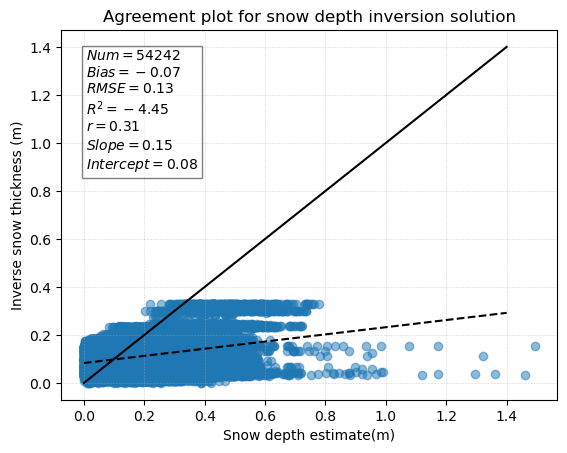

In [14]:
## snow
snow_inverse = np.array(snow_inverse)
snow_compare = np.array(snow_compare)
# Perform analysis
md, rmse, r2, slope, intercept = analyse(snow_inverse, snow_compare)

# Add grids
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.scatter(snow_compare, snow_inverse, alpha=0.5)
plt.plot([0,1.4] , [0,1.4], 'k-')
plt.xlabel('Snow depth estimate(m)')
plt.ylabel('Inverse snow thickness (m)')
plt.title("Agreement plot for snow depth inversion solution")

textstr = '\n'.join((
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Plot linear regression line
x_values = np.array([0,1.4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')
plt.show()


## ICE

In [15]:
inverse_ice_files = ['images/FB_interp_2018-2019_25km_20190406.npy_ice',
                'images/FB_interp_2018-2019_25km_20190412.npy_ice',
                'images/FB_interp_2018-2019_25km_20190419.npy_ice',
                'images/FB_interp_2018-2019_25km_20190420.npy_ice',
                'images/FB_interp_2018-2019_25km_20190422.npy_ice']

ice_CS_file = nc.Dataset("/home/sraz/coding/MSCI_2021_Project3/snow_ice_thickness/IS2_01012019-31122019.nc")
ice_CS = [ice_CS_file.variables['Sea Ice Thickness'][95, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][101, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][108, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][109, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][111, :,:]]
ice_CS_file.close()


In [16]:
ice_inverse =[]
ice_compare = []


for i in range(5):
    ice_inverse_data = np.loadtxt(inverse_ice_files[i])
    ice_inverse_data = mask_observations(ak,ice_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (ice_CS[i].mask[k][j]) and not np.isnan(ice_inverse_data[k][j]):
                ice_inverse.append(ice_inverse_data[k][j])
                ice_compare.append(ice_CS[i].data[k][j])


In [17]:
# pearson result
r_ice = pearson(ice_inverse, ice_compare)

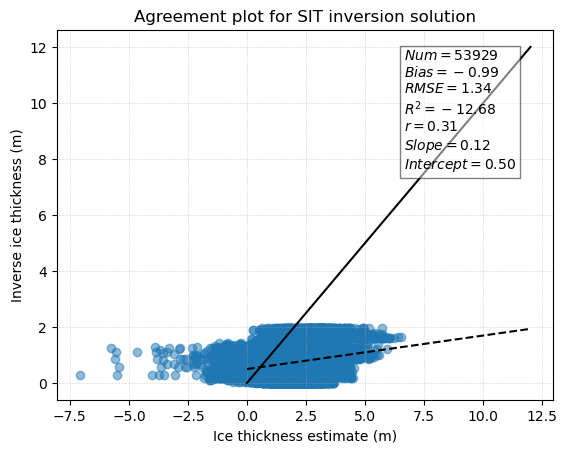

In [19]:
ice_inverse = np.array(ice_inverse)
ice_compare = np.array(ice_compare)
# Perform analysis
md, rmse, r2, slope, intercept = analyse(ice_inverse, ice_compare)

# Add grids
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.scatter(ice_compare, ice_inverse, alpha=0.5)
plt.plot([0,12] , [0,12], 'k-')
plt.xlabel('Ice thickness estimate (m)')
plt.ylabel('Inverse ice thickness (m)')
plt.title("Agreement plot for SIT inversion solution")

textstr = '\n'.join((
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.7, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Plot linear regression line
x_values = np.array([0,12])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')
plt.show()